In [55]:
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

In [56]:
from __future__ import absolute_import, division, print_function
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
path="C:/Users/Sanket.Shenvi/Desktop/Data Analytics/Deep_Learning/malaria/cell-images-for-detecting-malaria/cell_images"
print(os.listdir(path))

['Parasitized', 'Uninfected']


In [57]:
infected = os.listdir(path+'/Parasitized') 
uninfected = os.listdir(path+'/Uninfected')

In [58]:
data = []
labels = []

for i in infected:
    try:
    
        image = cv2.imread(path+'/Parasitized/'+i)
        image_array = Image.fromarray(image , 'RGB')
        resize_img = image_array.resize((50 , 50))
        rotated45 = resize_img.rotate(45)
        rotated75 = resize_img.rotate(75)
        blur = cv2.blur(np.array(resize_img) ,(10,10))
        data.append(np.array(resize_img))
        data.append(np.array(rotated45))
        data.append(np.array(rotated75))
        data.append(np.array(blur))
        labels.append(1)
        labels.append(1)
        labels.append(1)
        labels.append(1)
        
    except AttributeError:
        print('')
    
for u in uninfected:
    try:
        
        image = cv2.imread(path+'/Uninfected/'+u)
        image_array = Image.fromarray(image , 'RGB')
        resize_img = image_array.resize((50 , 50))
        rotated45 = resize_img.rotate(45)
        rotated75 = resize_img.rotate(75)
        data.append(np.array(resize_img))
        data.append(np.array(rotated45))
        data.append(np.array(rotated75))
        labels.append(0)
        labels.append(0)
        labels.append(0)
        
    except AttributeError:
        print('')

In [59]:
cells = np.array(data)
labels = np.array(labels)

np.save('Cells' , cells)
np.save('Labels' , labels)

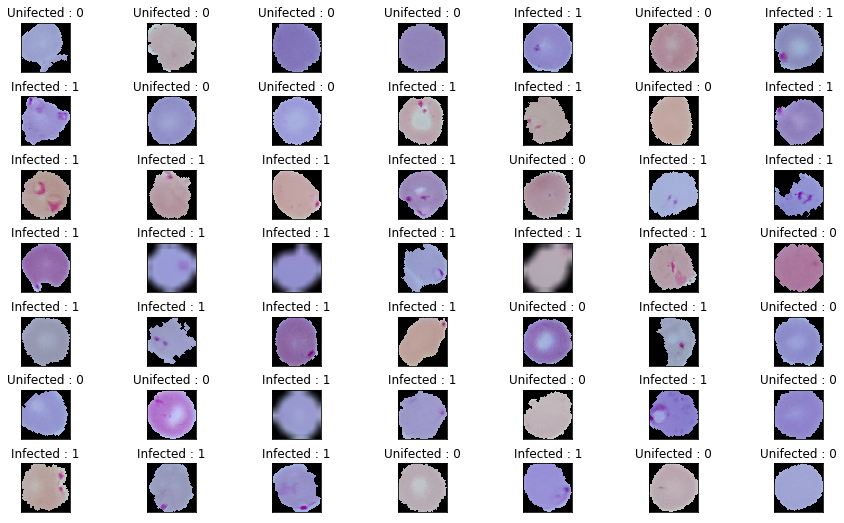

In [60]:
plt.figure(1 , figsize = (15 , 9))
n = 0
for i in range(49):
    n += 1 
    r = np.random.randint(0 , cells.shape[0] , 1)
    plt.subplot(7 , 7 , n)
    plt.subplots_adjust(hspace = .5 , wspace = .5)
    plt.imshow(cells[r[0]])
    plt.title('{} : {}'.format('Infected' if labels[r[0]] == 1 else 'Unifected' ,
                               labels[r[0]]) )
    plt.xticks([]) , plt.yticks([])
  
plt.show()

In [61]:
n = np.arange(cells.shape[0])
np.random.shuffle(n)
cells = cells[n]
labels = labels[n]

cells = cells.astype(np.float32)
labels = labels.astype(np.int32)
cells = cells/255

In [62]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(cells , labels ,test_size = 0.2 ,random_state = 111)


In [64]:
X_train.shape

(77162, 50, 50, 3)

In [81]:
def convolutional_block(X,f,filters,stage,block,s):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
    X_shortcut = X
    #1 Main Path
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    #2 Main Path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    #3 Main Path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)
    #Short Path
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)
    #Addition
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    return X

In [82]:
def identity_block(X, f, filters, stage, block):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
    X_shortcut = X
    #1 Main Path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    #2 Main Path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    #3 Main Path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
    X =  Add()([X, X_shortcut])
    X = Activation('relu')(X) 
    return X

In [137]:
def Resnet(shape,classes):
    X_input = shape
    X = ZeroPadding2D((3, 3))(X_input)
    #Stage1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')
    # Stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')
    # Stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')
    # Stage 5
    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')
    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    X=Flatten()(X)
    X = Dense(classes, activation='sigmoid', name='fc' + str(classes))(X)
    return X

In [143]:
def Resnet50(input_shape):
    X_input = Input(input_shape)
    X=Resnet(X_input,1)
    model = Model(inputs = X_input, outputs = X, name='Resnet50') 
    return model

In [144]:
Resnet50 = Resnet50(X_train.shape[1:])

In [145]:
### START CODE HERE ### (1 line)
Resnet50.compile(optimizer='adam',loss='mean_squared_error')
### END CODE HERE ###

In [149]:
Resnet50.fit(X_train, Y_train, epochs=5, batch_size=100,verbose=1)

Epoch 1/5
 1100/77162 [..............................] - ETA: 14:13:07 - loss: 0.3896

KeyboardInterrupt: 

In [150]:
### START CODE HERE ### (1 line)
preds = happyModel.evaluate(X_test, Y_test, batch_size=2, verbose=1, sample_weight=None)
### END CODE HERE ###
print()
print ("Loss = " + str(preds))

RuntimeError: You must compile a model before training/testing. Use `model.compile(optimizer, loss)`.

In [ ]:
### START CODE HERE ###
img_path = 'C:/Users/Sanket.Shenvi/Desktop/Data Analytics/Deep_Learning/nonmalaria.jpg'
### END CODE HERE ###
img = image.load_img(img_path, target_size=(50, 50))
imshow(img)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

print(happyModel.predict(x))